In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Activation,Dropout,Flatten,Dense,GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
import numpy as np
seed = 9
np.random.seed(seed=seed)
# tf.set_random_seed(seed=seed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
transformation_ratio = 0.05
momentum = 0.9
img_width,img_height = 416,416
batch_size = 4
# nb_epoch= 100
learn_rate = 1e-4
nb_classes = 2

In [3]:
train_data_dir = 'data/train'
validation_data_dir = 'data/val'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=15,
#                                    vertical_flip=True,
                                   fill_mode='reflect',
                                   data_format='channels_last',
                                   brightness_range=[0.5, 1.5],
                                   featurewise_center=True,
                                   featurewise_std_normalization=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_width, img_height),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')

label_map = (train_generator.class_indices)
print(label_map)

Found 394 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
{'person_no_seatbelt': 0, 'person_seatbelt': 1}


In [4]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

In [5]:
# base_lr = 1e-4
path_to_weights = "./model_weights/custom_weights-{epoch:02d}-{val_loss:.2f}.h5"
callbacks_list = [
    ModelCheckpoint(path_to_weights,monitor = 'val_loss',verbose = 1,save_weights_only = False),
#     EarlyStopping(monitor = 'val_loss',patience = 5,verbose = 1)
#     LearningRateScheduler(schedule,verbose = 1)
]


In [6]:
input_shape = (416,416,3)
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='Same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='Same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='Same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='Same', activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256,(3, 3), padding='Same', activation='relu'))
# model.add(Conv2D(256,(3, 3), padding='Same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='Same', activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512,(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(512,(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='Same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='Same', activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(GlobalAveragePooling2D())
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 416, 416, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 208, 208, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 208, 208, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 104, 104, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 104, 104, 128)     7

In [8]:
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999),
            metrics=['accuracy'])

In [9]:
394//4

98

In [10]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = 98,
                              epochs = 10,
                              validation_data = validation_generator,
                              callbacks = callbacks_list,
#                              samples_per_epoch = train_generator.samples,
#                              nb_epoch= nb_epoch,
#                              validation_data = validation_generator,
#                               nb_val_samples = validation_generator.samples,
#                               callbacks = callbacks_list,
                              )


Epoch 1/10
98/98 [==============================] - 229s 2s/step - loss: 0.3950 - accuracy: 0.8000 - val_loss: 0.4384 - val_accuracy: 0.6500

Epoch 00001: saving model to .model_weights/custom_weights-01-0.44.h5
Epoch 2/10
98/98 [==============================] - 220s 2s/step - loss: 0.2641 - accuracy: 0.8949 - val_loss: 0.3828 - val_accuracy: 0.9500

Epoch 00002: saving model to .model_weights/custom_weights-02-0.38.h5
Epoch 3/10
98/98 [==============================] - 219s 2s/step - loss: 0.1814 - accuracy: 0.9667 - val_loss: 0.4067 - val_accuracy: 0.8000

Epoch 00003: saving model to .model_weights/custom_weights-03-0.41.h5
Epoch 4/10
98/98 [==============================] - 218s 2s/step - loss: 0.2762 - accuracy: 0.9282 - val_loss: 0.3077 - val_accuracy: 0.9333

Epoch 00004: saving model to .model_weights/custom_weights-04-0.31.h5
Epoch 5/10
98/98 [==============================] - 226s 2s/step - loss: 0.1667 - accuracy: 0.9436 - val_loss: 0.1061 - val_accuracy: 0.9500

Epoch 0000

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


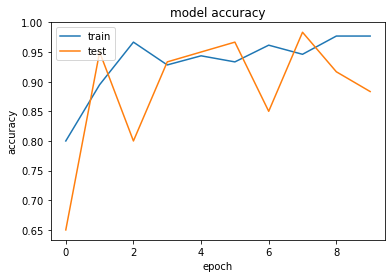

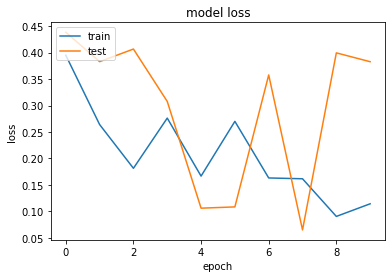

In [12]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
score = model.evaluate_generator(validation_generator, validation_generator.samples/batch_size, workers=12)
# print(score)

In [41]:
# scores = model.predict_generator(validation_generator, validation_generator.samples/batch_size, workers=12)

correct = 0
for i, n in enumerate(validation_generator.filenames):
#     print(n)
    if n.startswith("person_no_seatbelt") and scores[i][0] >= 0.5:
        correct += 1
    if n.startswith("person_seatbelt") and scores[i][0] < 0.5:
        correct += 1

print("Correct:", correct, " Total: ", len(validation_generator.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])

Correct: 15  Total:  60
Loss:  0.3827793300151825 Accuracy:  0.8833333253860474
